In [484]:
import os
from matplotlib import pyplot as plt
import numpy as np
from subprocess import Popen, PIPE

from itertools import compress
from scipy.ndimage import correlate
import math

In [643]:
pipe = Popen ("./pendulum-dimension", stdin=PIPE, stdout=PIPE, shell=True)

In [542]:
def read_results_from_pipe ():
    results = []
    
    num_lines = int(pipe.stdout.readline())
    print ("Reading %i lines" % num_lines)

    for _ in range(num_lines):
        results.append (float(pipe.stdout.readline ()))
    
    return results

def run_simu_chunk (locations):
    locations_string = list(map (lambda loc: "%i %i %i" % loc, locations))
    locations_string = str(len(locations)) + "\n" + "\n".join(locations_string) + "\n"
    
    pipe.stdin.write(bytes(locations_string.encode("utf8")))
    pipe.stdin.flush ()
    
    results = read_results_from_pipe ()
    
    return dict(zip (locations, results))

def run_simu (locations):
    split_num = math.ceil(len(locations) / 512.0**2)
    arrays = np.array_split (locations, split_num)
    
    results = {}
    
    for array in arrays:
        array = list(map(tuple, array))
        results.update (run_simu_chunk (array))
    
    return results

In [499]:
pow_2 = 7
detail = 2**pow_2

locations = list(zip(np.indices ((detail,detail))[0].ravel(), np.indices ((detail,detail))[1].ravel()))
locations_string = list(map (lambda x: "%i %i %i" % (pow_2, x[0], x[1]), locations))
locations_string = str(len(locations_string)) + "\n" + "\n".join(locations_string) + "\n"

In [56]:
pipe.stdin.write(bytes(locations_string.encode("utf8")))

11358216

In [57]:
pipe.stdin.flush ()

In [58]:
num_lines = int(pipe.stdout.readline())

print ("Reading %i lines" % num_lines)

results = []

for _ in range(num_lines):
    results.append (float(pipe.stdout.readline ()))

Reading 1048576 lines


In [59]:
indices = np.array(locations)

In [60]:
arr = np.zeros ((detail, detail))

In [61]:
arr[indices[:,0], indices[:, 1]] = results

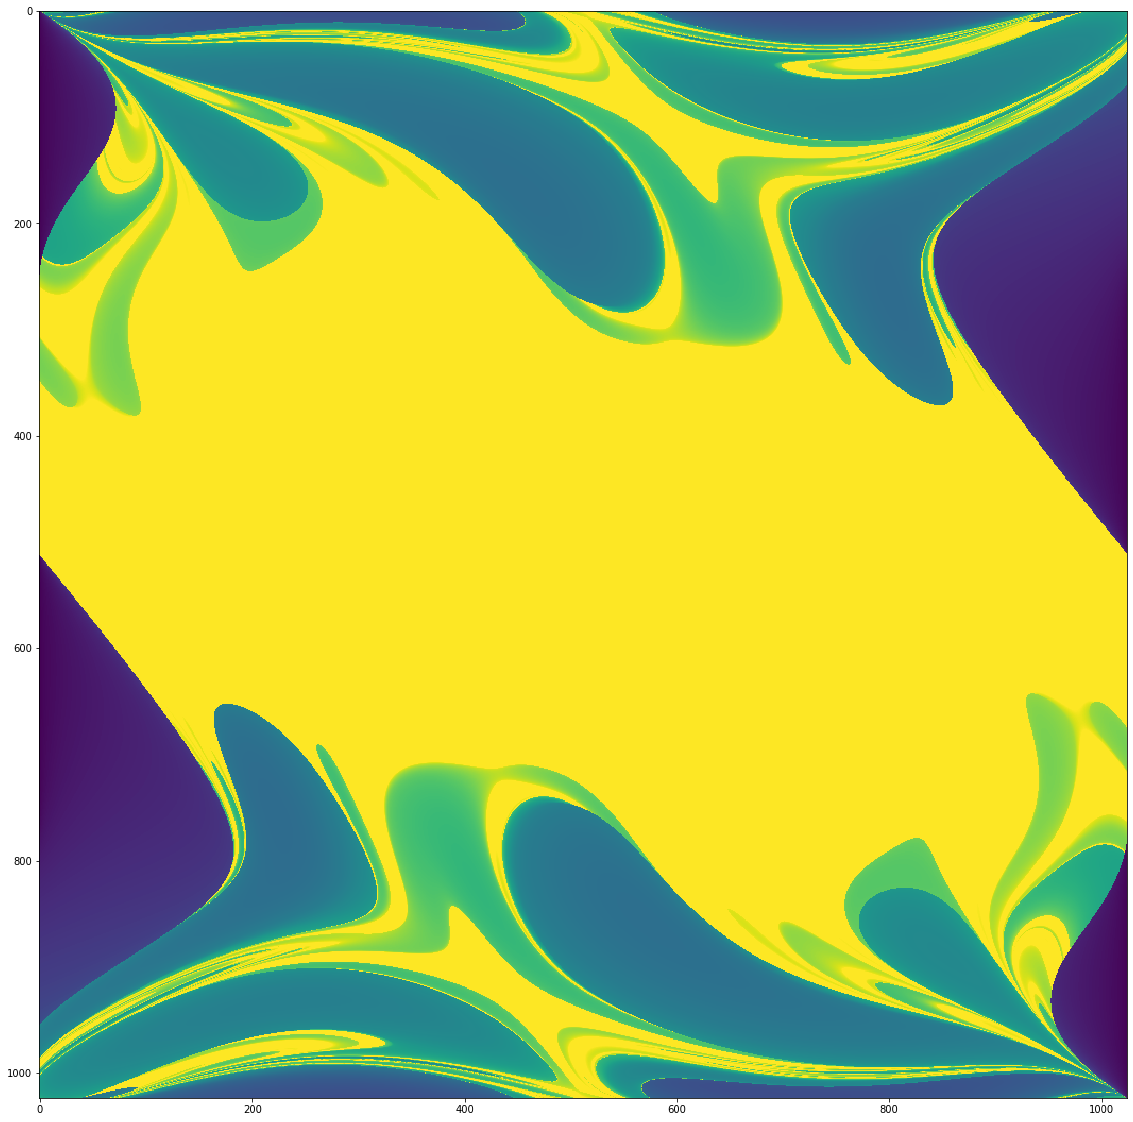

In [63]:
plt.figure (figsize=(20,20))
plt.imshow(arr)

In [68]:
grids = [{}]*20

In [ ]:
unprocessed = []

In [310]:
def simplify_loc (loc):
    if loc[1] % 2 == 0 and loc[2] % 2 == 0 and loc[0] > 0:
        return simplify_loc((loc[0]-1, loc[1]//2, loc[2]//2))
    else:
        return loc

def location_to_2d (loc):
    return [loc[1] / 2**loc[0], loc[2] / 2**loc[0]]

In [585]:
neighbourhood_sub_grid = [0, 0, 4]

def get_neighbourhood (loc, half_sizes = neighbourhood_sub_grid):
    
    neighbourhood = set()
    
    for extra_depth, half_size in enumerate(half_sizes, 1):
        depth = loc[0] + extra_depth
        
        x, y = np.indices((half_size * 2 + 1, half_size * 2 + 1)) - half_size
        x = x + loc[1] * 2
        y = y + loc[2] * 2
        
        neighbourhood |= set(map(lambda xy: simplify_loc((depth,) + xy), zip(x.ravel(), y.ravel())))
    
    return list(neighbourhood)

def get_sub_grid (loc, depth, extra_padding = 0):
    half_size = 2**(depth-1) + extra_padding
    
    x, y = np.indices((half_size * 2 + 1, half_size * 2 + 1)) - half_size
    depth_arr = np.ones_like (x) * (loc[0] + depth)
    
    x += loc[1] * 2**depth
    y += loc[2] * 2**depth
    
    return np.apply_along_axis(simplify_loc, 2, np.dstack ((depth_arr, x,y)))

In [586]:
get_sub_grid ((1,1,0), 1)

array([[[ 2,  1, -1],
        [ 2,  1,  0],
        [ 2,  1,  1]],

       [[ 2,  2, -1],
        [ 1,  1,  0],
        [ 2,  2,  1]],

       [[ 2,  3, -1],
        [ 2,  3,  0],
        [ 2,  3,  1]]])

In [313]:
get_neighbourhood ((1, 0, 0), [1])

[(2, -1, 1),
 (2, 1, 0),
 (2, 0, -1),
 (2, -1, 0),
 (2, 1, 1),
 (2, 1, -1),
 (0, 0, 0),
 (2, 0, 1),
 (2, -1, -1)]

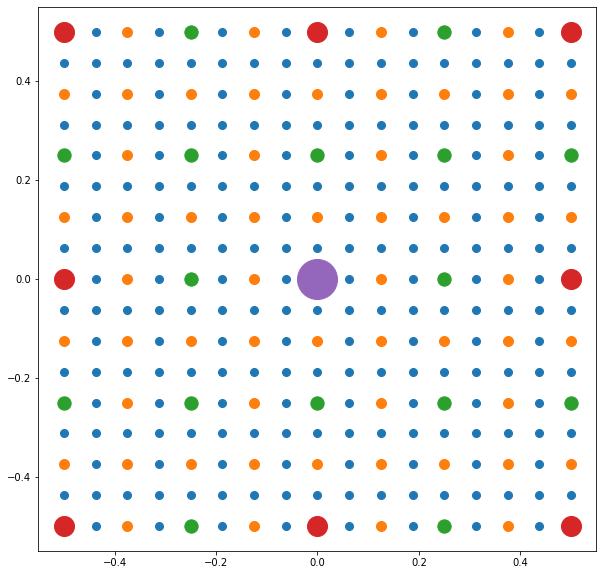

In [202]:
plt.figure (figsize=(10,10))

for d in reversed(range(4)):
    points = np.array(list(map(location_to_2d, get_neighbourhood ((0,0,0), [0]*d + [2**d]))))
    plt.plot (points[:, 0], points[:, 1], "o", markersize=40/(d+2))

plt.plot (0, 0, "o", markersize=40);

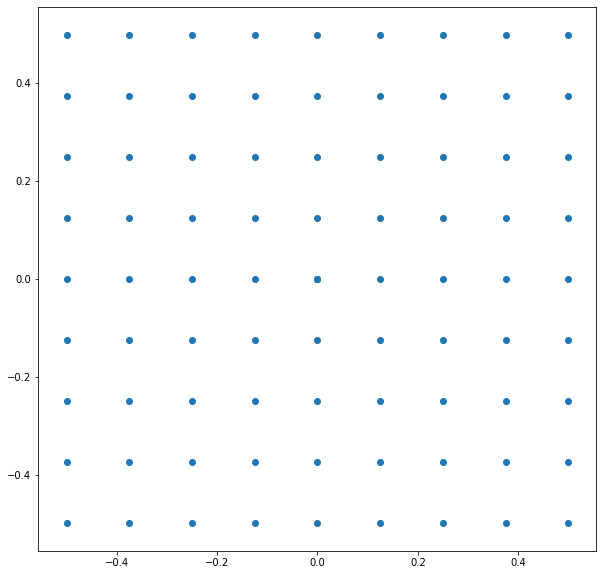

In [207]:
plt.figure (figsize=(10,10))

points = np.array(list(map(location_to_2d, get_neighbourhood ((0,0,0), [0, 0, 4]))))
plt.scatter (points[:, 0], points[:, 1])

In [653]:
kernel_half_size = 1
correlation_kernel = -1 * np.ones ((kernel_half_size * 2 + 1, kernel_half_size * 2 + 1))
correlation_kernel[kernel_half_size, kernel_half_size] = (2*kernel_half_size+1)**2 - 1

def find_edges (neighbourhood_results):
    return correlate (neighbourhood_results, correlation_kernel) != 0

def register_edges (set_of_edge_locs):
    global unprocessed
    unprocessed |= set_of_edge_locs

def process_location (loc):
    global processing, results
    
    if loc not in results:
        processing.add (loc)
        return
    
    if loc in processing:
        print ("debug: already in processing")
        return
    
    neighbourhood = get_sub_grid (loc, 3, extra_padding = kernel_half_size)
    
    length = neighbourhood.shape[0]
    neighbourhood_list = neighbourhood.reshape ((length**2, 3))
    
    missing_bools = list(map(lambda l: tuple(l) not in results, neighbourhood_list))
    
    if np.any (missing_bools):
        processing |= set(map(tuple, compress(neighbourhood_list, missing_bools)))
        return
    
    neighbourhood_results = np.array([results[tuple(loc)] for loc in neighbourhood_list]).reshape ((length, length))
    
    is_on_edge = find_edges (neighbourhood_results)
    
    register_edges (set(map(tuple, neighbourhood[is_on_edge])))
    
    unprocessed.remove (loc)

In [658]:
print ("processing:", len(processing))
print ("unprocessed:", len(unprocessed))
print ("results:", len(results))

processing: 0
unprocessed: 1947
results: 5449


In [465]:
for loc in get_neighbourhood ((0,0,0), [0,0,5]):
    results[loc] = 1

In [466]:
results[(0,0,0)] = 0

In [651]:
processing = set ()
unprocessed = set (map(tuple, get_sub_grid ((0,0,0), 3).reshape(((2**3+1)**2, 3))))
results = {}

for _ in range(3):
    processing = set ()
    
    for loc in unprocessed.copy():
        process_location (loc)
    
    if len(processing) == 0:
        break
    
    results.update(run_simu (list(processing)))

Reading 81 lines
Reading 5368 lines


In [645]:
len(unprocessed)

1943

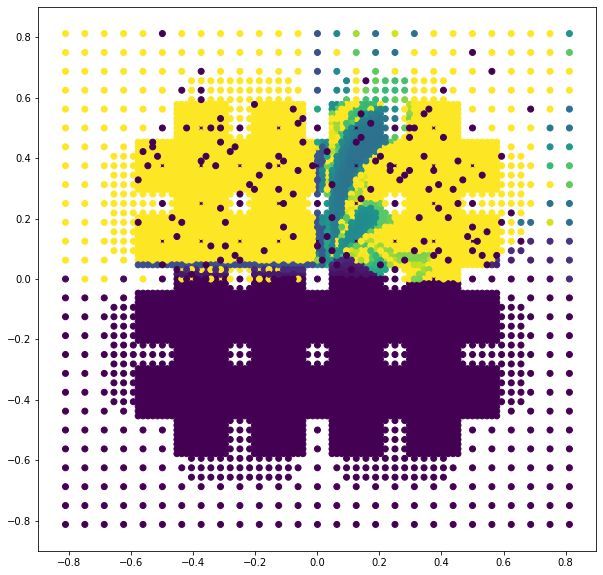

In [666]:
plt.figure (figsize=(10,10))

pts = np.array(list(map(location_to_2d, list(results.keys()))))
plt.scatter (pts[:,0], pts[:,1], c=list(results.values()))